In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import datetime
from typing import Dict
import pandas as pd

In [60]:
from ray import tune

In [61]:
import run_sampler, models, data_utils

In [62]:
state = "Maharashtra" # "Kerala"
state_pop = {
    "Maharashtra": 112374333,
    "Kerala": 34800000
}
start_date = datetime.datetime(2021, 3, 1)

In [63]:
analysis = run_sampler.tuning_exp(
    state,
    state_pop[state],
    hyp_config={
        "beta": tune.uniform(0.05, 1.2),
        "eps": tune.uniform(1. / 15., 1. / 3.),
        "mu": tune.loguniform(1. / 15, 1. / 7),
        "rho": tune.loguniform(1e-4, 1e-2),
        "p_d": tune.loguniform(0.005, 0.05),
    },
    start_date=start_date,
    num_samples=200,
    par_factor=(1./15)
)

2021-05-15 00:09:20,836	INFO tune.py:549 -- Total run time: 43.19 seconds (42.98 seconds for the tuning loop).
Best config:  {'beta': 0.19365648273198854, 'eps': 0.20844980868655538, 'mu': 0.1023811610469191, 'rho': 0.003103543797943415, 'p_d': 0.010439194343643944}


array([[<AxesSubplot:title={'center':'kl_div'}>]], dtype=object)

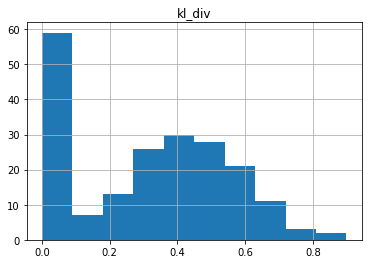

In [64]:
analysis.results_df.hist("kl_div")

In [65]:
config = analysis.best_result["config"]
model = models.seird(**config)

In [66]:
covid_data_india_by_state = data_utils.load_covid_data_india()
covid_data_mh = covid_data_india_by_state.get(state)

In [67]:
start_mh = covid_data_mh[covid_data_mh.Date == start_date].iloc[-1]
I0 = int(start_mh.Confirmed - (start_mh.Cured + start_mh.Deaths))
R0 = (start_mh.Cured)
D0 = start_mh.Deaths

In [72]:
model.simulate(
    timesteps=covid_data_mh[covid_data_mh.Date >= start_date].shape[0] - 1 + 60,
    t_min=1,
    start_date=start_date.date(),
    S=state_pop[state]-I0,
    E=0,
    I=I0,
    R=R0,
    D=D0
)

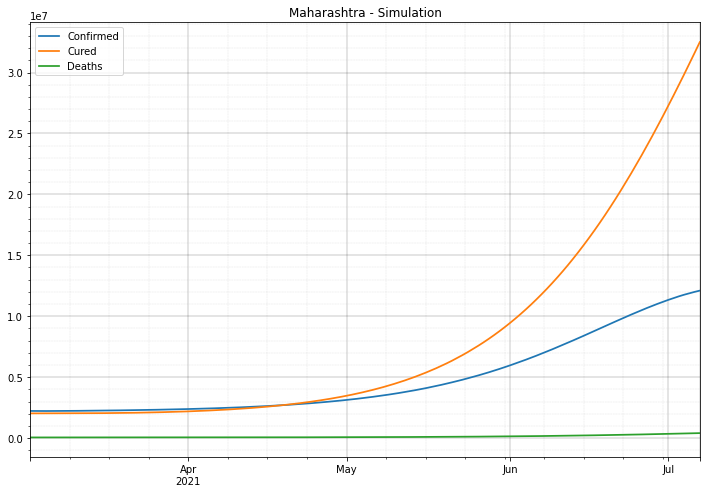

In [73]:
res = pd.DataFrame({
    "Confirmed": model.I + start_mh.Confirmed,
    "Cured": model.R,
    "Deaths": model.D
})
ax1 = res.plot(figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax1.legend(['Confirmed', 'Cured', 'Deaths'])
ax1.minorticks_on()
ax1.grid(True, which='major', linestyle='-', linewidth=0.25, axis='both', alpha=0.85, color="black")
ax1.grid(True, which='minor', linestyle='-.', linewidth=0.25, axis='both', alpha=0.7)

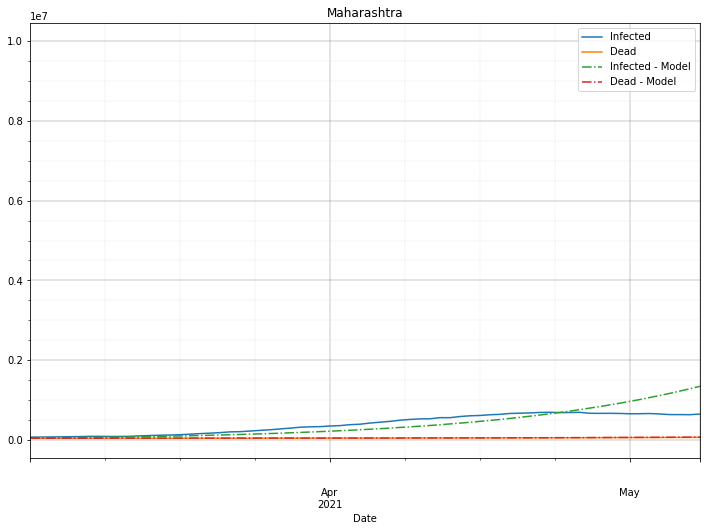

In [74]:
ax = data_utils.plot_covid_data_state(
    covid_data_india_by_state,
    state=state,
    start_date=start_date,
    population=state_pop[state]
)
ax.plot(model.I, linestyle='-.')
ax.plot(model.D, linestyle='-.')
ax.legend(["Infected", "Dead", "Infected - Model", "Dead - Model"])


[]

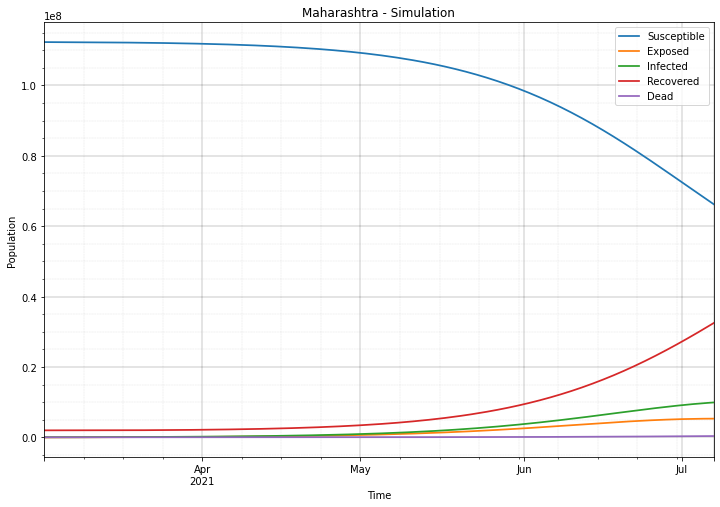

In [75]:
ax0 = model.plot(normed=False, figsize=(12, 8), linewidth=1.75, title=f"{state} - Simulation")
ax0.legend(['Susceptible', 'Exposed', 'Infected', 'Recovered', 'Dead'])
ax0.plot()

In [76]:
config

{'beta': 0.19365648273198854,
 'eps': 0.20844980868655538,
 'mu': 0.1023811610469191,
 'rho': 0.003103543797943415,
 'p_d': 0.010439194343643944}